# Battle of Neighbourhoods
## 1. Introduction 
## 1.1 Description of the Problem
New York is known as a state of diverse population. That explains that there are a lot of restaurants with food from different parts of the world.
The problem starts with finding a suitable neighborhood place to open a Latin food restaurant.

## 2.2 Discussion of the Background
A customer wants to open a Latin food restaurant in the Bronx district of New York City.
Since the district is wide, he wants to know a specific neighborhood which can be conducive to opening his business.


## 2. Description of data
In this project we will use a public database used in previous examples seen in previous modules and Foursquare data

First, libraries and tools necessary for the project are imported

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    li

## 2.1 New York data
The New York neighborhood information database is imported and they are sorted by columns in a data table

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Only Bronx district data is filtered in a different data table.

In [7]:
bronx_data=neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
bronx_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## 2.2 Foursquare data
Foursware API will be used to get Bronx neighborhoods venues information to be able to determinate de best neighborhood to open a Latin Food restaurant.
This data is determined by neighborhoods's latitud and longitude and it is limited to 100 venues and 500 meters of radio

## 2.3 How data will be used to solve the problem
Both, NY neighborhoods and Foursquare data are going to determine the most suitable neighborhood to open a latin food restaurant by using k-means metodology.

# 3. Methodology

Firt we have to obtain Foursquare data for Bronx's neighborhoods.

In [8]:
address = 'Bronx, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bronx are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bronx are 40.85048545, -73.8404035580209.


In [9]:
CLIENT_ID = 'VQJQ4ZOFBMGM0L3J43GXUM52IXIPNXNLX1KGGNY2KXZHSFT0' # your Foursquare ID
CLIENT_SECRET = 'V3GSJ32HU1CFEXBEL5TSEVN43AESJDNSZUCNKZYEA2PCVAHM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VQJQ4ZOFBMGM0L3J43GXUM52IXIPNXNLX1KGGNY2KXZHSFT0
CLIENT_SECRET:V3GSJ32HU1CFEXBEL5TSEVN43AESJDNSZUCNKZYEA2PCVAHM


In [10]:
bronx_data.shape

(52, 4)

In [11]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
bronx_venues = getNearbyVenues(names=bronx_data['Neighborhood'],
                                   latitudes=bronx_data['Latitude'],
                                   longitudes=bronx_data['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Claremont Village
Concourse Village
Mount Eden
Mount Hope
Bronxdale
Allerton
Kingsbridge Heights


Now, lets find out which neighborhood has most latin american restaurants

In [13]:
bronx_latin=bronx_venues.loc[bronx_venues['Venue Category']=='Latin American Restaurant'].reset_index()

In [14]:
bronx_latin.head(18)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,65,Kingsbridge,40.881687,-73.902818,Leche y Miel,40.883709,-73.901606,Latin American Restaurant
1,102,Kingsbridge,40.881687,-73.902818,Silhouette Restaurant & Lounge,40.880706,-73.902687,Latin American Restaurant
2,118,Kingsbridge,40.881687,-73.902818,Hola España,40.879160,-73.904553,Latin American Restaurant
3,307,University Heights,40.855727,-73.910416,Liberato,40.853744,-73.907966,Latin American Restaurant
4,325,Morris Heights,40.847898,-73.919672,Mamajuana,40.844938,-73.920950,Latin American Restaurant
5,328,Fordham,40.860997,-73.896427,188 Bakery Cuchifritos,40.861602,-73.898311,Latin American Restaurant
6,379,Fordham,40.860997,-73.896427,Parilla Latina,40.861009,-73.891945,Latin American Restaurant
7,456,West Farms,40.839475,-73.877745,"El Salvadoreño, bar & restaurante",40.840689,-73.872961,Latin American Restaurant
8,469,High Bridge,40.836623,-73.926102,Justine Restaurant,40.835502,-73.921439,Latin American Restaurant
9,528,Mott Haven,40.806239,-73.916100,Rincon Ecuatoriano,40.803689,-73.911951,Latin American Restaurant


In [15]:
bronx_latin.shape

(18, 8)

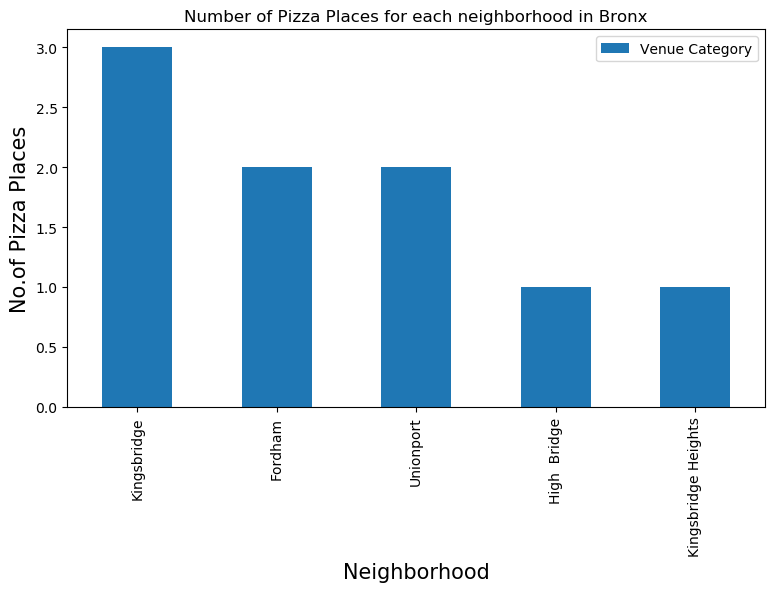

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Pizza Places for each neighborhood in Bronx')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Pizza Places', fontsize=15)
#giving a bar plot
bronx_latin.groupby('Neighborhood')['Venue Category'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

According to last bar graph the neighborhood with most latin american restaurants is Kingsbridge.
Now, lets find out every venue from each neighborhood and it's predominance

In [17]:
# one hot encoding
bronx_onehot = pd.get_dummies(bronx_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bronx_onehot['Neighborhood'] = bronx_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bronx_onehot.columns[-1]] + list(bronx_onehot.columns[:-1])
bronx_onehot = bronx_onehot[fixed_columns]

bronx_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Boat or Ferry,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Eye Doctor,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Home Service,Hookah Bar,Hotel,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Lake,Latin American Restaurant,Laundromat,Lawyer,Liquor Store,Lounge,Market,Martial Arts Dojo,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moving Target,Music Store,Music Venue,Nail Salon,Nightclub,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Rental Car Location,Restaurant,River,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Social Club,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Tattoo Parlor,Tennis Court,Tennis Stadium,Thai Restaurant,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waste Facility,Wine Shop,Wings Joint,Women's Store
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [18]:
bronx_grouped = bronx_onehot.groupby('Neighborhood').mean().reset_index()
bronx_grouped

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Boat or Ferry,Bookstore,Bowling Alley,Breakfast Spot,Brewery,Buffet,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,Eye Doctor,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Food,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Home Service,Hookah Bar,Hotel,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Lake,Latin American Restaurant,Laundromat,Lawyer,Liquor Store,Lounge,Market,Martial Arts Dojo,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moving Target,Music Store,Music Venue,Nail Salon,Nightclub,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Rental Car Location,Restaurant,River,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Smoke Shop,Social Club,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Tattoo Parlor,Tennis Court,Tennis Stadium,Thai Restaurant,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waste Facility,Wine Shop,Wings Joint,Women's Store
0,Allerton,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.096774,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.096774,0.032258,0.032258,0.000000,0.032258,0.000000,0.00000,0.000000,0.032258,0.000000,0.032258,0.00,0.000000,0.032258,0.000000,0.000000,0.000000,0.032258,0.00000,0.000000,0.000000,0.032258,0.00,0.000000,0.032258,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.032258,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.032258,0.00,0.096774,0.00,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.032258,0.00,0.0,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.064516,0.000000,0.00,0.00,0.000,0.000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,Baychester,0.000000,0.000000,0.045455,0.045455,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.045455,0.000000,0.0

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bronx_grouped['Neighborhood']

for ind in np.arange(bronx_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bronx_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Chinese Restaurant,Supermarket,Fast Food Restaurant,Martial Arts Dojo,Breakfast Spot,Spanish Restaurant,Food,Smoke Shop
1,Baychester,Electronics Store,Donut Shop,Pizza Place,Bank,Men's Store,Fast Food Restaurant,Mattress Store,Spanish Restaurant,Sandwich Place,Fried Chicken Joint
2,Bedford Park,Diner,Mexican Restaurant,Pizza Place,Supermarket,Chinese Restaurant,Sandwich Place,Bus Station,Fried Chicken Joint,Deli / Bodega,Train Station
3,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Grocery Store,Dessert Shop,Donut Shop,Spanish Restaurant,Bank,Sandwich Place
4,Bronxdale,Italian Restaurant,Spanish Restaurant,Bank,Pizza Place,Performing Arts Venue,Paper / Office Supplies Store,Chinese Restaurant,Eastern European Restaurant,Mexican Restaurant,Breakfast Spot


## K-MEANS

To apply this method, it is necesaary to find out an appropriate value of K, so we are goinf to aplicate Elbow Method and Silhouette Coefficient.


## Elbow Method

The elbow method is used to solve the problem of selecting k. Interestingly, the elbow method is not perfect either but it gives significant insight that is perhaps not top optimal but sub-optimal to choosing the optimal number of clusters by fitting the model with a range of values for k.

The approach for this is to run the k-means clustering for a range of value k and for each value of k, the Sum of the Squared Errors (SSE) is calculated., calculate sum of squared errors (SSE). When this is done, a plot of k and the corresponding SSEs are then made. At the elbow (just like arm), that is where the optimal value of k is. And that will be the number of clusters to be used. The whole idea is to have minimum SSE

In [24]:
bronx_grouped_clustering =bronx_grouped.drop('Neighborhood', 1)

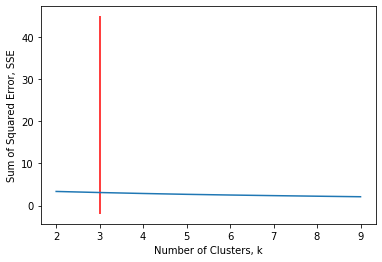

In [25]:
from sklearn.cluster import KMeans

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(bronx_grouped_clustering)
    bronx_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

Depending on the number of iteration (in this case, 500 iterations were used), the number of cluster, k is 3.

## Silhouette Coefficient

To find the optimal value of the number of clusters, k, the number of clusters is iterated corresponding Silhouette Coefficientis calculated for each of the k-values used. The highest Silhouette Coefficient gives the best match to its own cluster. Please see below:

In [26]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2, 10):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(bronx_grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(bronx_grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.6787637908476635
Where n_clusters = 3, the Silhouette Coefficient is 0.6406348689213593
Where n_clusters = 4, the Silhouette Coefficient is 0.6170280718679633
Where n_clusters = 5, the Silhouette Coefficient is 0.6239284792976618
Where n_clusters = 6, the Silhouette Coefficient is 0.650469587277814
Where n_clusters = 7, the Silhouette Coefficient is 0.6537983168861516
Where n_clusters = 8, the Silhouette Coefficient is 0.6647395678798047
Where n_clusters = 9, the Silhouette Coefficient is 0.6550315362017799


The value of k in which the coefficient is higher is the chosen one. In this case k = 3 

The method is applied with k = 3

In [27]:
# set number of clusters
kclusters = 3

bronx_grouped_clustering = bronx_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bronx_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50]

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1], dtype=int32)

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bronx_merged = bronx_data


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bronx_merged = bronx_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bronx_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,1,Ice Cream Shop,Sandwich Place,Gas Station,Caribbean Restaurant,Laundromat,Donut Shop,Dessert Shop,Pharmacy,Distillery,Dive Bar
1,Bronx,Co-op City,40.874294,-73.829939,0,Bus Station,Baseball Field,Grocery Store,Fast Food Restaurant,Fried Chicken Joint,Mattress Store,Chinese Restaurant,Bar,Restaurant,Pharmacy
2,Bronx,Eastchester,40.887556,-73.827806,0,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Metro Station,Platform,Bowling Alley,Pizza Place,Cosmetics Shop,Convenience Store
3,Bronx,Fieldston,40.895437,-73.905643,0,Plaza,Bus Station,River,Women's Store,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market
4,Bronx,Riverdale,40.890834,-73.912585,0,Bus Station,Park,Food Truck,Baseball Field,Plaza,Home Service,Gym,Bank,Fish Market,Fish & Chips Shop



The clusters formed are shown on the map

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bronx_merged['Latitude'], bronx_merged['Longitude'], bronx_merged['Neighborhood'], bronx_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
     
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters


Verify the clusters formed

#### Cluster 1

In [87]:
bronx_merged.loc[bronx_merged['Cluster Labels'] == 0, bronx_merged.columns[[1] + list(range(5, bronx_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Co-op City,Bus Station,Baseball Field,Grocery Store,Fast Food Restaurant,Fried Chicken Joint,Mattress Store,Chinese Restaurant,Bar,Restaurant,Pharmacy
2,Eastchester,Caribbean Restaurant,Bus Station,Deli / Bodega,Diner,Metro Station,Platform,Bowling Alley,Pizza Place,Cosmetics Shop,Convenience Store
3,Fieldston,Plaza,Bus Station,River,Women's Store,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market
4,Riverdale,Bus Station,Park,Food Truck,Baseball Field,Plaza,Home Service,Gym,Bank,Fish Market,Fish & Chips Shop
17,West Farms,Bus Station,Park,Supermarket,Deli / Bodega,Outdoors & Recreation,Pizza Place,Convenience Store,Playground,Donut Shop,Coffee Shop
18,High Bridge,Pharmacy,Pizza Place,Bus Station,Chinese Restaurant,Sandwich Place,Sports Club,Gym,Latin American Restaurant,Market,Food
24,Morrisania,Discount Store,Bus Station,Pizza Place,Grocery Store,Metro Station,Fast Food Restaurant,Donut Shop,Bowling Alley,Intersection,Liquor Store
25,Soundview,Chinese Restaurant,Pharmacy,Latin American Restaurant,Bus Stop,Breakfast Spot,Fried Chicken Joint,Basketball Court,Grocery Store,Playground,Video Store


#### Cluster 2

In [88]:
bronx_merged.loc[bronx_merged['Cluster Labels'] == 1, bronx_merged.columns[[1] + list(range(5, bronx_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Ice Cream Shop,Sandwich Place,Gas Station,Caribbean Restaurant,Laundromat,Donut Shop,Dessert Shop,Pharmacy,Distillery,Dive Bar
5,Kingsbridge,Pizza Place,Bar,Mexican Restaurant,Sandwich Place,Latin American Restaurant,Supermarket,Donut Shop,Spanish Restaurant,Bakery,Fried Chicken Joint
6,Woodlawn,Deli / Bodega,Bar,Playground,Pub,Pizza Place,Indian Restaurant,Plaza,Moving Target,Park,Donut Shop
7,Norwood,Pizza Place,Park,Bank,Mobile Phone Shop,Pharmacy,Fast Food Restaurant,Plaza,Supermarket,Restaurant,Chinese Restaurant
8,Williamsbridge,Playground,Soup Place,Nightclub,Bar,Caribbean Restaurant,Food,Fish & Chips Shop,Film Studio,Fast Food Restaurant,Farmers Market
9,Baychester,Electronics Store,Donut Shop,Pizza Place,Bank,Men's Store,Fast Food Restaurant,Mattress Store,Spanish Restaurant,Sandwich Place,Fried Chicken Joint
10,Pelham Parkway,Pizza Place,Bus Station,Italian Restaurant,Frozen Yogurt Shop,Deli / Bodega,Chinese Restaurant,Home Service,Gym / Fitness Center,Liquor Store,Gas Station
11,City Island,Harbor / Marina,Grocery Store,Thrift / Vintage Store,Seafood Restaurant,Pizza Place,Spanish Restaurant,Ice Cream Shop,History Museum,Italian Restaurant,Jewelry Store
12,Bedford Park,Diner,Mexican Restaurant,Pizza Place,Supermarket,Chinese Restaurant,Sandwich Place,Bus Station,Fried Chicken Joint,Deli / Bodega,Train Station
13,University Heights,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Bakery,Shoe Store,Sandwich Place,Supermarket,Donut Shop,Grocery Store,Latin American Restaurant


#### Cluster 3

In [89]:
bronx_merged.loc[bronx_merged['Cluster Labels'] == 2, bronx_merged.columns[[1] + list(range(5, bronx_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Clason Point,Park,Grocery Store,South American Restaurant,Pool,Boat or Ferry,Bus Stop,Electronics Store,Fish & Chips Shop,Film Studio,Fast Food Restaurant


The venues categories of Kingsbridge are verified

In [37]:
kingsbridge_data=bronx_venues.loc[bronx_venues['Neighborhood']=='Kingsbridge']

In [38]:
kingsbridge_data

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
64,Kingsbridge,40.881687,-73.902818,Garden Gourmet Market,40.881350,-73.903389,Gourmet Shop
65,Kingsbridge,40.881687,-73.902818,Leche y Miel,40.883709,-73.901606,Latin American Restaurant
66,Kingsbridge,40.881687,-73.902818,Kingsbridge Social Club,40.884545,-73.901964,Pizza Place
67,Kingsbridge,40.881687,-73.902818,El Malecon,40.879338,-73.904457,Caribbean Restaurant
68,Kingsbridge,40.881687,-73.902818,Sam's Pizza,40.879435,-73.905859,Pizza Place
69,Kingsbridge,40.881687,-73.902818,The Bronx Public,40.878377,-73.903481,Pub
70,Kingsbridge,40.881687,-73.902818,Carvel Ice Cream,40.883657,-73.901655,Ice Cream Shop
71,Kingsbridge,40.881687,-73.902818,Bronx Alehouse,40.884749,-73.899699,Beer Bar
72,Kingsbridge,40.881687,-73.902818,Loeser's Delicatessen,40.879111,-73.905693,Sandwich Place
73,Kingsbridge,40.881687,-73.902818,Smashburger,40.884221,-73.900333,Burger Joint


Now, let's find out the most common venue at Bronx district

In [33]:
bronx_venue_unique_count = bronx_venues['Venue Category'].value_counts().to_frame(name='Count')

In [36]:
bronx_venue_unique_count.head()

,Count
Pizza Place,101
Deli / Bodega,55
Donut Shop,45
Pharmacy,40
Italian Restaurant,39


# 4. Results

In resume, according to results shown before:
    - At Bronx district Pizza Place is the most common venue.
    - The neighborhood with the most Latin food restaurants is Kingsbridge. This neighborhood also seems to be a restaurants       district and an appropiate place to open a Latin food restaurant.
    - Cluster 2 shows that on those neighborhoods there is prenominance of restaurants and food places.
    

# 5. Discussion and Conclusion
It is very important to note that Clusters 2 is the most viable clusters to create a Latin American Restaurant. Their proximity to other amenities and accessibility to station are paramount. 

In conclusion, this project would have had better results if there were more data in terms of traffic access and the quantity of latin people living on those neighborhoods.
